# 12. Implementation of a Portfolio Strategy

This tutorial provides a step-by-step guide for implementing a Unit Operator with a Portfolio Strategy in the ASSUME framework. By the end of this guide, you will be familiar with the process of creating and integrating a Portfolio within the electricity market simulation environment provided by ASSUME.


**We will cover the following topics:**

1. [Introduction to Unit Operators and Portfolio Strategy](#1-introduction-to-unit-operators-and-portfolio-strategy)
2. [Setting up the ASSUME framework](#2-setting-up-assume)
3. [Developing a UnitOperatorStrategy](#3-developing-a-new-demand-side-unit)
4. [Formulating a rule-based bidding strategy](#4-rule-based-bidding-strategy)
5. [Integrating the new strategy into the ASSUME simulation](#5-integrating-the-new-strategy-into-assume)

## 1. Introduction to Units Operator and Portfolio Strategy

The ASSUME framework is a versatile tool for simulating electricity markets, allowing researchers and industry professionals to analyze market dynamics and strategies.

A **UnitsOperator** in ASSUME refers to a market role that submits buy or sell bids in the market for multiple units in its portfolio, according to the bidding strategy of each unit. Unit operators can themselves have a portfolio strategy, that is a **UnitOperatorStrategy**, which aims at optimizing the joint market returns from the bids of all units of the operator. 

In this tutorial, we will create a portfolio strategy for a unit operator with multiple units.

# Understanding pivotality

For the purpose of this tutorial, we will introduce the concept of pivotality:
For a given time period, a unit operator is **pivotal** if the market demand cannot be covered by the supply capacity without the capacity of the units in the operator's portfolio.


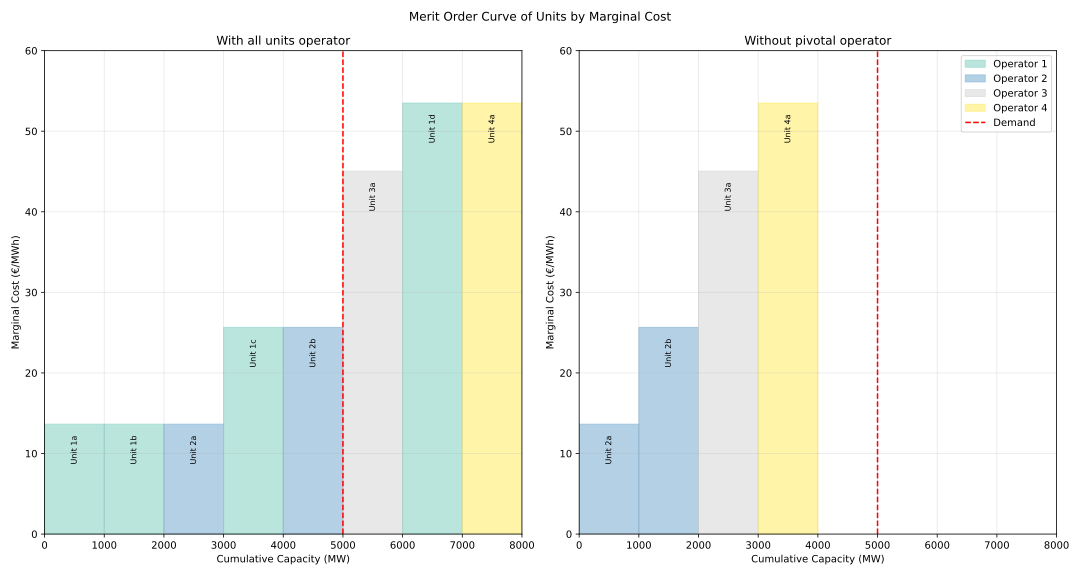

In [ ]:
# this cell is used to display the image in the notebook when using colab
# or running the notebook locally

import os
import matplotlib.pyplot as plt
from IPython.display import Image, display, SVG

image_path = "assume-repo/docs/source/img/pivotal_units_operator.svg"
alt_image_path = "../../docs/source/img/pivotal_units_operator.svg"

# Try to display SVG using different methods
if os.path.exists(image_path):
    display(SVG(image_path))
elif os.path.exists(alt_image_path):
    display(SVG(alt_image_path))
else:
    print("Image file not found. Please check the path.")


The picture provides a visual representation of the concept of pivotality. Both images represent the Merit Order Curve of the generation units in a market, sorted by their marginal cost and colored by their operator. The market demand is inflexible and amounts to 5000 MW.
- **Left-hand side**: complete Merit Order Curve
- **Right-hand side**: Merit Order Curve without Operator 1 (pivotal operator).

With pivotality, the unit operator has an incentive to bid extremely high prices for the units in its portfolio, as its generation capacity is required to clear the market. However, this behavior cannot be represented in the individual bidding strategy of the units, as none of them is individually pivotal. This is just an example of how optimal portfolio bidding may differ from optimal unit bidding.

## 2. Setting Up ASSUME

Before we create our custom unit, let's set up the ASSUME framework. We'll install the ASSUME core package and clone the repository containing predefined scenarios.

**You don't need to execute the following code cells if you already have the ASSUME framework installed and/or the repository cloned.**

In [1]:
import importlib.util

# Check if 'google.colab' is available
IN_COLAB = importlib.util.find_spec("google.colab") is not None
if IN_COLAB:
    !pip install assume-framework

In [14]:
if IN_COLAB:
    !git clone --depth=1 https://github.com/assume-framework/assume.git assume-repo

Note that Google Colab does not support Docker functionalities, so features dependent on Docker will not be available here.

**Select input files path**

We also need to differentiate between the input file paths when using this tutorial in Google Colab and a local environment. The code snippets will include both options for your convenience.

In [2]:
colab_inputs_path = "assume-repo/examples/inputs"
local_inputs_path = "../inputs"

inputs_path = colab_inputs_path if IN_COLAB else local_inputs_path

**Loading predefined scenario**

We load a predefined scenario with a strategic operator, **Operator 1**, which will implement portfolio-level strategies.

In [50]:
#TODO
import os, sys
sys.path.append(os.path.abspath("../../"))
from assume import World
from assume.scenario.loader_csv import load_scenario_folder
%load_ext autoreload
%autoreload 2

inputs_path = "../inputs"
db_uri = "sqlite:///../local_db/assume_db.db"

world = World(database_uri=db_uri, export_csv_path=f"outputs/12_portfolio_strategies")
load_scenario_folder(
    world,
    inputs_path=inputs_path,
    scenario="example_01i",
    study_case=False,
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO:assume.world:Connected to the database
INFO:assume.scenario.loader_csv:Input files path: ../inputs/example_01i
INFO:assume.scenario.loader_csv:Study case: False
INFO:assume.scenario.loader_csv:Simulation ID: example_01i_base
INFO:assume.scenario.loader_csv:storage_units not found. Returning None
INFO:assume.scenario.loader_csv:industrial_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:residential_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:forecasts_df not found. Returning None
INFO:assume.scenario.loader_csv:Downsampling demand_df successful.
INFO:assume.scenario.loader_csv:Downsampling exchanges_df successful.
INFO:assume.scenario.loader_csv:availability_df not found. Returning None
INFO:assume.scenario.loader_csv:buses not found. Returning None
INFO:assume.scenario.loader_csv:lines not found. Returning None
INFO:assume.scenario.loader_csv:save_freq

## 3. Developing a New Forecast

In order for the Units Operator to be able to act strategically when it is pivotal, it needs to have access to a forecast of total market demand and residual supply. The residual supply is the total available supply of units which do ***not*** belong to the unit operator. 

We equip the unit operator with a **CSVForecaster**, which is a Forecaster object that contains multiple datasets for a given scenario. The simulation automatically receives the **CSVForecaster** as an attribute when the scenario is loaded. We copy the global forecaster, and add an additional forecast - the residual supply for Operator 1.


In [19]:
from assume.common.fast_pandas import FastSeries
from assume.common.forecasts import CsvForecaster
from copy import deepcopy


def add_res_supply_forecast(global_forecaster:CsvForecaster, 
                            operator_id:str):
    """Creates a copy of a forecaster object which
    includes the residual supply without the operator, 
    calculated as the sum of the available capacity of
    all power plants that do not belong to it. 

    Args:
        global_forecaster(CSVForecaster): original forecaster
        operator_id(str): identifier of the UnitsOperator

    Returns:
        op_forecaster(CSVForecaster): forecaster of the UnitsOperator
     """
    
    op_forecaster = deepcopy(global_forecaster)
    fcst_dict = op_forecaster.forecasts
    fcst_name = f"res_supply_{operator_id}"

    if fcst_name in fcst_dict:
        return op_forecaster

    res_supply_forecast = FastSeries(
                    value=0.0, 
                    index=op_forecaster.index, 
                    name=fcst_name,
                )

    for unit_id, unit in op_forecaster.powerplants_units.iterrows():    
        if unit["unit_operator"] == operator_id:
            continue 
        
        else:
            # add to the residual supply 
            availability = fcst_dict[f"availability_{unit_id}"]
            res_supply_forecast+= (availability * unit["max_power"])
        
    fcst_dict[fcst_name] = res_supply_forecast
    return op_forecaster


## 4. Developing a New Portfolio Strategy

Now, we'll define a rule-based portfolio strategy for a Units Operator. This strategy will use market information on the demand forecast to place bids at a higher price if the operator expects to be pivotal. 

**Key features of a Portfolio Strategy**
1. **Overwrites unit bidding strategies**: If an operator has a portfolio strategy for a given market, the bidding strategies of its individual units will be ignored.
2. **Transforms a portfolio strategy into unit bids**: The portfolio-level strategy is translated into bids that are assigned to the units in the portfolio. This ensures that the market clearing can be used to determine the dispatch of the units. 
3. **Calculates operator reward**: Rewards are computed at a portfolio-level, if needed.

In [ ]:
from assume.strategies.portfolio_strategies import UnitOperatorStrategy
from assume.strategies.naive_strategies import NaiveSingleBidStrategy
from assume.common.market_objects import MarketConfig, Product, Orderbook
from datetime import timedelta

class PivotalityStrategy(UnitOperatorStrategy):

    def calculate_bids(
            self,
            units_operator,  # type: UnitsOperator
            market_config: MarketConfig,
            product_tuples: list[Product],
            **kwargs,
        ) -> Orderbook:
        """
        Takes information from a units operator and
        defines how the units managed by it should bid.

        This gives a lot of flexibility to the market bids.

        Args:
            units_operator (UnitsOperator): The operator handling the units.
            market_config (MarketConfig): The market configuration.
            product_tuples (list[Product]): The list of all products the unit can offer.

        Returns:
            Orderbook: The bids consisting of the start time, end time, only hours, price and volume.
        """
        
        op_bids = [] 
        op_id = units_operator.id
        market_id = market_config.market_id

        demand_fcst =  units_operator.forecaster[f"demand_{market_id}"]
        res_supply_fcst  = units_operator.forecaster[f"res_supply_{op_id}"]
        uncovered_demand = (demand_fcst - res_supply_fcst)

        for unit in units_operator.units.values():
            unit_bids = NaiveSingleBidStrategy().calculate_bids(unit, market_config, product_tuples)
            # if operator is pivotal in a given hour, increase bid price to maximum possible bid
            
            for bid in unit_bids:
                if uncovered_demand[bid["start_time"]] > 0:
                    bid["price"] = market_config.maximum_bid_price
            
            op_bids.extend(unit_bids)
        
        return op_bids

    
    def calculate_reward(
        self,
        units_operator,  # type: UnitsOperator
        marketconfig: MarketConfig,
        orderbook: Orderbook,
    ):
        """
        Calculates the reward for the given unit.

        Args:
            units_operator (UnitsOperator): The operator handling the units.
            marketconfig (MarketConfig): The market configuration.
            orderbook (Orderbook): The orderbook.
        """
        #TODO: 



## 5. Modifying the UnitsOperator in ASSUME

Now we'll test integrating our updated forecaster and portfolio strategy into the ASSUME simulation environment.

First, we'll define and run a simulation without any portfolio optimization as a baseline test, saving results to "XXXXX/baseline". 

In [ ]:
world.run()

Next we define and run the simulation again, this time adding a portfolio strategy and a forecaster to the units operator, saving results to "XXX/with_portfolio_opt".

In [ ]:
operator_1 = world.unit_operators["Operator 1"]
# add the forecaster to the operator
op_forecaster = add_res_supply_forecast(world.forecaster, "Operator 1")
operator_1.forecaster = op_forecaster
# add the dictionary of portfolio strategies by market_id to the operator
# add new bidding strategy to world
world.bidding_strategies["portfolio_pivotality"] = PivotalityStrategy
operator_1.portfolio_strategies = {"EOM": PivotalityStrategy()}

# run the simulation
world.run()

After running both simulations, we can now compare them through loading the CSV output files and plotting the results. To make visualisation easier, we focus on a random 24 hour period (in this case, 2019-01-03).

First we plot the Power dispatch in the baseline case.

In [ ]:
import matplotlib.pyplot as ax0

fig = ax0.figure(figsize=(20, 10))

ax0.plot(
    demand_power_dfs["baseline"].index.to_list(),
    demand_power_dfs["baseline"]["power"],
    label="Demand",
)
ax0.plot(
    wp_power_dfs["baseline"].index.to_list(),
    wp_power_dfs["baseline"]["power"],
    label="Power Plant",
)
ax0.plot(
    gp_power_dfs["baseline"].index.to_list(),
    gp_power_dfs["baseline"]["power"],
    label="Gas Plant",
)
ax0.xlabel("time")
ax0.ylabel("Power Dispatch (MW)")
ax0.title("Power Dispatch without Electrolyser")

ax0.legend()
ax0.show()

In the plot above, what's most noticeable is that the Power Plant sufficiently meets the load requirements, and the Gas Plant is never on. ("+" values = Generation, "-" values = Load).

Now we'll see how adding the Electrolyser affects Power Dispatch. 

In [ ]:
market_orders_dfs = {}
wp_price_dfs = {}
gp_price_dfs = {}
demand_price_dfs = {}
electrolyser_price_dfs = {}

for test in test_types:
    market_orders_dfs[test] = pd.read_csv(
        f"outputs/electrolyser_demo/{test}/market_orders.csv", index_col="start_time"
    )
    market_orders_dfs[test].index = pd.to_datetime(market_orders_dfs[test].index)

    wp_price_dfs[test] = market_orders_dfs[test][
        market_orders_dfs[test]["unit_id"] == "power_plant_01"
    ].loc["2019-01-03":"2019-01-03"]
    gp_price_dfs[test] = market_orders_dfs[test][
        market_orders_dfs[test]["unit_id"] == "gas_plant_01"
    ].loc["2019-01-03":"2019-01-03"]
    demand_price_dfs[test] = market_orders_dfs[test][
        market_orders_dfs[test]["unit_id"] == "demand_unit_01"
    ].loc["2019-01-03":"2019-01-03"]

    if test == "with_electrolyser":
        electrolyser_price_dfs[test] = market_orders_dfs[test][
            market_orders_dfs[test]["unit_id"] == "electrolyser_01"
        ].loc["2019-01-03":"2019-01-03"]

In [ ]:
fig = ax0.figure(figsize=(20, 10))

ax0.plot(
    wp_price_dfs["baseline"].index.to_list(),
    wp_price_dfs["baseline"]["price"],
    label="Power Plant",
)
ax0.plot(
    gp_price_dfs["baseline"].index.to_list(),
    gp_price_dfs["baseline"]["price"],
    label="Gas Plant",
)
ax0.plot(
    wp_price_dfs["baseline"].index.to_list(),
    wp_price_dfs["baseline"]["accepted_price"],
    label="Accepted Price",
    color="r",
)
ax0.xlabel("time")
ax0.ylabel("Bid Price (€/MWh)")
ax0.title("Bid Prices without Electrolyser")

ax0.legend()
ax0.show()

As expected, since in the baseline case only cheaper power from the Power Plant is required, the accepted price is always that of the Power Plant (€5/MWh). Note that the Bid Price of Demand is not included in the plot for the sake of visualisation as it is significantly larger than the others (and so is essentially guaranteed to be accepted).

In [ ]:
fig = ax0.figure(figsize=(20, 10))

ax0.plot(
    wp_price_dfs["with_electrolyser"].index.to_list(),
    wp_price_dfs["with_electrolyser"]["price"],
    label="Power Plant",
)
ax0.plot(
    gp_price_dfs["with_electrolyser"].index.to_list(),
    gp_price_dfs["with_electrolyser"]["price"],
    label="Gas Plant",
)
ax0.plot(
    electrolyser_price_dfs["with_electrolyser"].index.to_list(),
    electrolyser_price_dfs["with_electrolyser"]["price"],
    label="Electrolyser",
)
ax0.plot(
    wp_price_dfs["with_electrolyser"].index.to_list(),
    wp_price_dfs["with_electrolyser"]["accepted_price"],
    label="Accepted Price",
    color="r",
)
ax0.xlabel("time")
ax0.ylabel("Bid Price (€/MWh)")
ax0.title("Bid Prices with Electrolyser")

ax0.legend()
ax0.show()

With the addition of the Electrolyser, we see that the accepted price fluctuates between that of the Power Plant and that of the Gas Plant, based on how much power the Electrolyser is demanding. The Electrolyser's power demand is always met as it is always willing to pay ~€140/MWh and the Gas Plant provides it at €25/MWh.

When we defined and ran the simulation above, it was similar to the implementation in Tutorial 1. It is verbose, showing all inner workings and serves for a better understanding. 

For more practical applications you should use the construct from Tutorial 2 to have an automated loading and execution of the scenario, where all parameters are defined in a configuration file, as in the following code block.

In the following cell, we automatically load the scenario (with input csv files from "inputs/example_01e"), add the newly defined custom unit, it's bidding strategy, and load these into the simulation. Note that the input data is slightly different to that in the simulation above, with there being just a single power plant capable of meeting the Load requirements from both Demand and the Electrolyser.

After the simulation you can now check out the simulation results in the output folder (outputs/example_01e_base/). For example, take a look at the market_dispatch.csv file to see the dispatch of the units in the market.

This concludes our tutorial. By following these steps, you have successfully created a Demand Side Unit with a Rule-Based Bidding Strategy and integrated it into the ASSUME framework.